In [1]:
%matplotlib inline
from IPython.core.magics.execution import TimeitResult
from typing import NamedTuple
import matplotlib.pyplot as plt

In [2]:
import torch
import scipy
import cupy as cp
import numpy as np
import pyfftw

In [3]:
from libertem.common.shape import Shape

In [4]:
class Result(NamedTuple):
    stack: TimeitResult
    framewise: TimeitResult

In [5]:
# res.loops #: (int) number of loop done per measurement
# res.repeat  #: (int) number of time the mesurement has been repeated
# res.best  #: (float) best execusion time / number
# res.all_runs # (list of float) execusion time of each run (in s)
# res.timings 

In [6]:
stack_sizes = (2, 4, 8, 16, 32, 64)
sig_shapes = {(64, 64): ':', (128, 128): '-.', (256, 256): '--', (512, 512): '-'}

## np.fft

In [7]:
raise

RuntimeError: No active exception to reraise

In [ ]:
np_results = {}
xp = np
fft = np.fft

for stack_size in stack_sizes:
    for sig_shape in sig_shapes.keys():
        warmup_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        fft.fft2(warmup_data)
        fft.fft2(warmup_data[0])
        stack_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        print(f'SHAPE : {stack_data.shape}')        
        res_stack = %timeit -o fft.fft2(stack_data)
        frame_data = [f.copy() for f in stack_data]
        res_frame = %timeit -o [fft.fft2(f) for f in frame_data]
        np_results[Shape(stack_data.shape, sig_dims=2)] = Result(res_stack, res_frame)

## cupy.fft

In [ ]:
cp_results = {}
xp = cp
fft = cp.fft

for stack_size in stack_sizes:
    for sig_shape in sig_shapes.keys():
        warmup_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        fft.fft2(warmup_data)
        fft.fft2(warmup_data[0])
        stack_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        print(f'SHAPE : {stack_data.shape}')
        res_stack = %timeit -o fft.fft2(stack_data).get()
        frame_data = [f.copy() for f in stack_data]
        res_frame = %timeit -o [fft.fft2(f).get() for f in frame_data]
        cp_results[Shape(stack_data.shape, sig_dims=2)] = Result(res_stack, res_frame)

## pyFFTW x scipy.fftpack

In [ ]:
pfftw_results = {}
xp = np
fft = pyfftw.interfaces.scipy_fftpack

for stack_size in stack_sizes:
    for sig_shape in sig_shapes.keys():
        warmup_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        fft.fft2(warmup_data)
        fft.fft2(warmup_data[0])
        stack_data = xp.random.uniform(size=(stack_size, *sig_shape)).astype(xp.float32)
        print(f'SHAPE : {stack_data.shape}')
        res_stack = %timeit -o fft.fft2(stack_data)
        frame_data = [f.copy() for f in stack_data]
        res_frame = %timeit -o [fft.fft2(f) for f in frame_data]
        pfftw_results[Shape(stack_data.shape, sig_dims=2)] = Result(res_stack, res_frame)

## Plotting

In [ ]:
fig, ax = plt.subplots()
for (name, color), results in {
    ('cp.fft', 'r'): cp_results,    
    ('pyfftw.scipy_fftpack', 'b'): pfftw_results,  
    ('np.fft', 'k'): np_results,
}.items():
    accx = list(sorted(stack_sizes))
    accy = {s: [-1] * len(accx) for s in sig_shapes.keys()}
    for shape, res in results.items():
        stack_size = shape.nav.size
        idx = accx.index(stack_size)
        accy[shape.sig.to_tuple()][idx] = np.mean(res.stack.timings) / np.mean(res.framewise.timings)
    for idx, (sig_shape, shape_results) in enumerate(reversed(accy.items())):
        line_style = sig_shapes[sig_shape]
        legend = {'label': f'{name} - {sig_shape}'}  if line_style == '-' else {}
        if not legend and name == 'np.fft':
            legend = {'label': f'{sig_shape}'}
        ax.plot(accx, shape_results, 'x', color=color, linestyle=line_style, **legend)
ax.set_xlabel('Stack size')
ax.set_ylabel('$t_{stack} / t_{framewise}$');
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('fft2() - stack / framewise processing time');

## Test as UDF

In [8]:
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.common.backend import set_use_cuda, set_use_cpu
from stack_utils import NeedsFrame, DoesFFTFrame, DoesFFTStack

In [9]:
max_sig_shape = (512, 512)
max_n_frames = 2048
dtype = np.float32

In [10]:
data = np.random.uniform(size=(max_n_frames, *max_sig_shape)).astype(dtype)
path = './data.raw'
data.tofile(path)

In [11]:
print(f'{np.dtype(dtype).itemsize * data.size / 2**20} MB file')

2048.0 MB file


In [12]:
set_use_cpu(0)
ctx = lt.Context.make_with('inline')

Warmup to get all data in cache:

In [13]:
ds = ctx.load('raw_m', path, tile_depth=5, nav_shape=(max_n_frames,), sig_shape=max_sig_shape, dtype=dtype)
_ = ctx.run_udf(ds, SumUDF())

In [14]:
raise

RuntimeError: No active exception to reraise

In [ ]:
num_frames = 512
np_results = {}

for stack_size in stack_sizes:
    for sig_shape in sig_shapes.keys():
        sh = Shape((stack_size,) + sig_shape, sig_dims=2)
        ds = ctx.load('raw_m', path, tile_depth=stack_size, nav_shape=(num_frames,), sig_shape=sig_shape, dtype=dtype)
        print(sh, ds.get_num_partitions())        
        _ = ctx.run_udf(ds, SumUDF())
        res_stack = %timeit -o ctx.run_udf(ds, [NeedsFrame(), DoesFFTStack()])
        ds = ctx.load('raw', path, nav_shape=(num_frames,), sig_shape=sig_shape, dtype=dtype)
        _ = ctx.run_udf(ds, SumUDF())
        res_frame = %timeit -o ctx.run_udf(ds, [NeedsFrame(), DoesFFTFrame()])
        np_results[sh] = Result(res_stack, res_frame)

## CuPy

In [15]:
set_use_cuda(0)
ctx = lt.Context.make_with('inline')

In [16]:
ds = ctx.load('raw_m', path, tile_depth=5, nav_shape=(max_n_frames,), sig_shape=max_sig_shape, dtype=dtype)
_ = ctx.run_udf(ds, SumUDF())

In [17]:
num_frames = 512
cp_results = {}

for stack_size in stack_sizes:
    for sig_shape in sig_shapes.keys():
        sh = Shape((stack_size,) + sig_shape, sig_dims=2)
        ds = ctx.load('raw_m', path, tile_depth=stack_size, nav_shape=(num_frames,), sig_shape=sig_shape, dtype=dtype)
        print(sh, ds.get_num_partitions())        
        _ = ctx.run_udf(ds, SumUDF())
        res_stack = %timeit -o ctx.run_udf(ds, [NeedsFrame(), DoesFFTStack()])
        ds = ctx.load('raw', path, nav_shape=(num_frames,), sig_shape=sig_shape, dtype=dtype)
        _ = ctx.run_udf(ds, SumUDF())
        res_frame = %timeit -o ctx.run_udf(ds, [NeedsFrame(), DoesFFTFrame()])
        cp_results[sh] = Result(res_stack, res_frame)

(2, 64, 64) 1
66.1 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
67.5 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(2, 128, 128) 1
76.5 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.7 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(2, 256, 256) 1
111 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
130 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(2, 512, 512) 1
212 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
292 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(4, 64, 64) 1
39.3 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
67.3 ms ± 703 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(4, 128, 128) 1
48.9 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.7 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(4, 256, 256) 1
80.3 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 10 lo

## Plotting

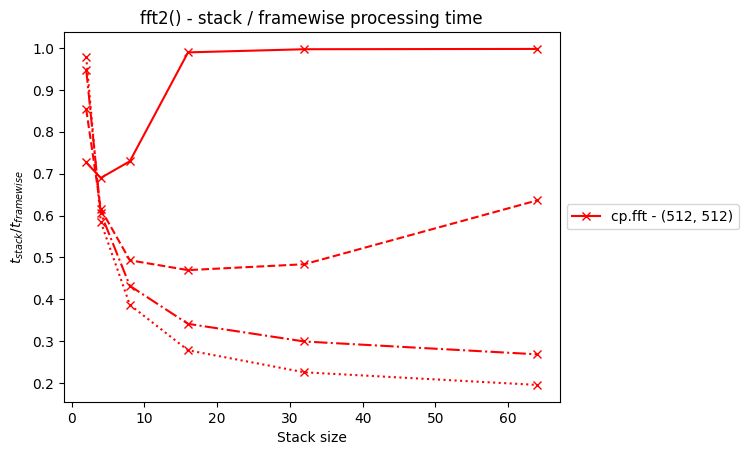

In [19]:
fig, ax = plt.subplots()
for (name, color), results in {
    ('cp.fft', 'r'): cp_results,    
    # ('pyfftw.scipy_fftpack', 'b'): pfftw_results,
    # ('np.fft', 'k'): np_results,
}.items():
    accx = list(sorted(stack_sizes))
    accy = {s: [-1] * len(accx) for s in sig_shapes.keys()}
    for shape, res in results.items():
        stack_size = shape.nav.size
        idx = accx.index(stack_size)
        accy[shape.sig.to_tuple()][idx] = np.mean(res.stack.timings) / np.mean(res.framewise.timings)
    for idx, (sig_shape, shape_results) in enumerate(reversed(accy.items())):
        line_style = sig_shapes[sig_shape]
        legend = {'label': f'{name} - {sig_shape}'}  if line_style == '-' else {}
        if not legend and name == 'np.fft':
            legend = {'label': f'{sig_shape}'}
        ax.plot(accx, shape_results, 'x', color=color, linestyle=line_style, **legend)
ax.set_xlabel('Stack size')
ax.set_ylabel('$t_{stack} / t_{framewise}$');
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('fft2() - stack / framewise processing time');